*Перед началом работы:*

In [1]:
pip install -U scikit-learn lightgbm phik optuna catboost -q

Note: you may need to restart the kernel to use updated packages.


**Импорт библиотек**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time 
import optuna

from scipy import stats
from IPython.display import display

# модули для работы с моделями:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Кодировщики, масштабировние
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# CatBoost и LGBM
import catboost, lightgbm
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor

# Метрики
from sklearn.metrics import mean_squared_error, root_mean_squared_error

import phik

**Константы**

In [6]:
RANDOM_STATE = 42

**Используемые в работе функции**

In [7]:
# Функция для отображения части датасета и информации о нем
def show_info(df):
    display(df.head())
    df.info()

In [8]:
### Предобработка данных ###
# 1. Для поиска и просмотра явных дубликатов:
def duplicates_find(df):
    
    # Если дубликаты есть:    
    if df.duplicated().sum()>0:
        # Количество явных дубликатов
        print ('Количество явных дубликатов:', df.duplicated().sum())
        print ('Процент от всего датасета:', df.duplicated().sum() / len(df) * 100)
        # Выводим на экран дубликаты
        display(df.loc[df.duplicated()])
    # Если дубликатов нет:
    else:
        print ('Явных дубликатов не найдено')
        
# 2. Для просмотра уникальных значений объектов типа Object: 
def uniques(df):
    for column in df.columns:
        if df[column].dtype == 'O':
            print (f'{column}: \n {df[column].unique()} \n ')

In [9]:
## Построение графиков

# 1. Гистограмма и ящик с усами для числовых признаков
def graph(df, bins, x_name):
    f, ax = plt.subplots(1, 2)
    f.set_size_inches(12, 4)
    plt.suptitle(f'{x_name}', fontweight='bold')
    # Гистограмма:
    sns.histplot(data=df, bins=bins, color='coral', edgecolor=None, ax=ax[0])
    ax[0].set_title('Гистограмма распределения')
    ax[0].grid()
    ax[0].set_xlabel(x_name)
    ax[0].set_ylabel('частота')
    # Ящик с усами:
    ## vert=False, чтобы значения признака были по горизонтальной оси для обоих графиков
    sns.boxplot(data=df, orient='h', color='cornflowerblue')
    ax[1].set_title('Ящик с усами')
    ax[1].grid()
    ax[1].set_xlabel(x_name)
    plt.show()
    
    display(pd.DataFrame(df.describe()).T)
    
# Для дискретных величин с горизонтальным отображением
def make_countplot(df, y, ylabel):
    plt.figure(figsize=(10, 4))
    sns.countplot(y=y, data=df, palette='pastel', order=df[y].value_counts().index)
    plt.title(y)
    plt.grid()
    plt.ylabel(ylabel)
    plt.xlabel('Частота')
    plt.show()    
    
# Для анализа остатков:
def make_hist(df, column, bins, p, x_name, title):
    f, ax = plt.subplots(1, 2)
    f.set_size_inches(20, 5)
    plt.suptitle(f'{p}', fontweight='bold')
    # Гистограмма:
    sns.histplot(data=df, x=column, bins=bins, color='coral', edgecolor=None, ax=ax[0])
    ax[0].set_title(f'{title}')
    ax[0].grid()
    ax[0].set_xlabel(x_name)
    ax[0].set_ylabel('частота')
    # Ящик с усами:
    ## vert=False, чтобы значения признака были по горизонтальной оси для обоих графиков
    sns.boxplot(data=df, x=column, orient='h', color='cornflowerblue')
    ax[1].set_title(f'Ящик с усами')
    ax[1].grid()
    ax[1].set_xlabel(x_name)
    plt.show()
    
def build_joint_hist(y_test, y_pred, df_num, title):
    y_joint = pd.DataFrame(list(zip(y_test, y_pred)), columns=['y_val', 'y_pred'])
    make_hist(y_joint, None, 50, df_num, 'евро', title)
    display(y_joint.describe().T)

## **Подготовка данных**

### Загрузка данных

In [10]:
data = pd.read_csv('C:/Я.Практикум/проекты/7_численные_методы/autos.csv')
show_info(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Вывод:**

354369 строк, 16 столбцов.

Типы:
1. int - 7 столбцов: 
    - 'Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode'
2. object - 9 столбцов:
    - 'DateCrawled', 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired', 'DateCreated', 'LastSeen'

Пропуски имеем в следующих столбцах:
- VehicleType, Gearbox, Model, FuelType, Repaired, 


Целевой признак - `Price`



Для модели несущественными могут быть признаки: 
- `PostalCode`(почтовый индекс владельца анкеты),
- `LastSeen`(дата последней активности пользователя)

### Предобработка данных

Для удобства работы переименуем некоторые столбцы и приведем все к нижнему регистру:

In [11]:
data.columns = data.columns.str.lower()
data = data.rename(columns={'registrationmonth':'registration_month', 'registrationyear':'registration_year', 
                            'vehicletype':'vehicle_type', 'fueltype':'fuel_type', 
                            'numberofpictures':'number_of_pictures', 'datecrawled':'date_crawled', 
                            'datecreated':'date_created'})
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [12]:
duplicates_find(data)

Количество явных дубликатов: 4
Процент от всего датасета: 0.0011287669068118262


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postalcode,lastseen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


* Удалим дубликаты позднее

#### Удаление неинформативных признаков

**Даты**

Приведем `date_crawled`, `date_created`, `lastseen` к типу datetime.  
Посмотрим, какие максимальные и минимальные даты имеем:

In [13]:
def retype (df, column):
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d %H:%M:%S')
    return (df)

for i in ['date_crawled', 'date_created', 'lastseen']:
    retype(data, i)

# Посмотрим, какие максимальные и минимальные даты имеем:
for i in ['date_crawled', 'date_created', 'lastseen']:
    print (f'{i}: min - {data[i].min()}, max - {data[i].max()}')

date_crawled: min - 2016-03-05 14:06:22, max - 2016-04-07 14:36:58
date_created: min - 2014-03-10 00:00:00, max - 2016-04-07 00:00:00
lastseen: min - 2016-03-05 14:15:08, max - 2016-04-07 14:58:51


Данные были выгружены примерно в один промежуток времени, в течение месяца. Даты последней активности пользователя тоже отличаются максимум на месяц. Т.к. нет значимого разброса, то нет и смысла оставлять эти признаки в датасете - они не окажут влияния.

Проверим, как часто встречаются разные даты создания анкеты:

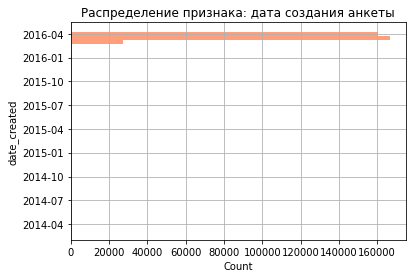

In [14]:
sns.histplot(data=data, y='date_created', bins=50, color='coral', edgecolor=None)
plt.title('Распределение признака: дата создания анкеты')
plt.grid()
plt.show()

- В основном все анкеты созданы в феврале-апреле 2016 года. Раньше - крайне редко.

**Удалим признаки `date_crawled`, `date_created`, `lastseen`, поскольку они не появлияют на таргет.**

In [15]:
data = data.drop(['date_crawled', 'date_created', 'lastseen'], axis=1)

**`postalcode`, `registration_month`, `number_of_pictures`**

Эти столбцы тоже не должны влиять на целевой признак. 


Убедимся в этом:

Для `number_of_pictures` посчитаем уникальные значения.    
Посмотрим зависимость таргета от оставшихся признаком (postalcode, registration_month) через phik:

In [16]:
# Для number_of_pictures посчитаем уникальные значения:
print ('Распределение значений в number_of_pictures:')
print (data['number_of_pictures'].unique())

# Посмотрим зависимость таргета от оставшихся признаком (postalcode, registration_month) через phik:
print ('\nЗависимость целевого признака от "postalcode", "registration_month", "registration_year":')

interval_cols = ['power', 'kilometer', 'postalcode', 'price']
data.drop('number_of_pictures', axis=1).phik_matrix(interval_cols=interval_cols).loc[
    ['price'], ['price', 'postalcode', 'registration_year', 'registration_month']]

Распределение значений в number_of_pictures:
[0]

Зависимость целевого признака от "postalcode", "registration_month", "registration_year":


,price,postalcode,registration_year,registration_month
price,1.0,0.096123,0.674549,0.177026


Вывод:

1. number_of_pictures:
    * Ни в одной из строк нет значения выше нуля. Удаляем этот признак.
        * Возможно, произошла техническая ошибка при записи или во время выгрузки.


2. postalcode:
    * Очень низкий уровень корреляции с таргетом. Что логично. Удаляем.


3. registration_month
    * Низкий уровень корреляции. Более того, есть признак "registration_year", который сильнее влияет на таргет.
    Месяц регистрации - удаляем.

**Удаляем**

In [17]:
data = data.drop(['postalcode', 'registration_month', 'number_of_pictures'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       316879 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            334536 non-null  object
 4   power              354369 non-null  int64 
 5   model              334664 non-null  object
 6   kilometer          354369 non-null  int64 
 7   fuel_type          321474 non-null  object
 8   brand              354369 non-null  object
 9   repaired           283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


**Вывод:**

Удалили неинформативные признаки:
- date_crawled, date_created, lastseen, 'postalcode', 'registration_month', 'number_of_pictures'

#### Пропуски

In [18]:
data.isna().sum()

price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

Для каждого столбца с пропущенными значениями выведем уникальные значения и их количество:

In [19]:
for i in data.isna().sum().loc[data.isna().sum()>0].index:
    print (f'{i}: ')
    display(data[i].value_counts())

vehicle_type: 


sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

gearbox: 


manual    268251
auto       66285
Name: gearbox, dtype: int64

model: 


golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: model, Length: 250, dtype: int64

fuel_type: 


petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

repaired: 


no     247161
yes     36054
Name: repaired, dtype: int64

**Решение**

Пропущенные значения в `fuel_type`, `model`, `vehicle_type` заполним значением 'other', т.к. такие категории имеются в этих столбцах.

В `repaired` заменим на новую категорию - 'unknown', поскольку в этом столбце всего 2 уникальных значения, и мы не можем с уверенностью утверждать, что пропуски означают "да" или "нет", а 71 тысяча из 350 тыс значений - это большая доля, и заполнение значений на "да" или "нет" может существенно исказить датасет.

То же касается и `gearbox` - заменим на 'unknown', чтобы не искажать значения.

In [20]:
# Замена
for column in 'fuel_type', 'model', 'vehicle_type':
    data[column] = data[column].fillna('other')
for column in 'repaired', 'gearbox':
    data[column] = data[column].fillna('unknown')

# Проверка корректности заполнения
print ('Пропуски после заполнения:')
display (data.isna().sum())
print ('Уникальные значения и их количества в колонках repaired и gearbox после заполнения:')
display (data['repaired'].value_counts())
display (data['gearbox'].value_counts())

Пропуски после заполнения:


price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

Уникальные значения и их количества в колонках repaired и gearbox после заполнения:


no         247161
unknown     71154
yes         36054
Name: repaired, dtype: int64

manual     268251
auto        66285
unknown     19833
Name: gearbox, dtype: int64

* Пропуски заполнены успешно

#### Дубликаты

**Явные дубликаты:**

In [21]:
duplicates_find(data)

Количество явных дубликатов: 45191
Процент от всего датасета: 12.752526321433308


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1117,950,small,1999,manual,60,polo,150000,petrol,volkswagen,no
1396,0,other,2000,unknown,0,other,150000,other,volvo,unknown
2169,0,coupe,2002,manual,129,c_klasse,150000,petrol,mercedes_benz,no
2833,1499,small,2001,manual,58,corsa,150000,petrol,opel,no
3025,2800,wagon,2005,unknown,0,touran,150000,gasoline,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
354352,6500,sedan,2003,auto,145,e_klasse,150000,gasoline,mercedes_benz,no
354355,4400,sedan,2008,manual,105,leon,150000,gasoline,seat,no
354358,1490,small,1998,manual,50,lupo,150000,petrol,volkswagen,no
354359,7900,sedan,2010,manual,140,golf,150000,gasoline,volkswagen,no


Дубликатов после обработки данных стало много. 

Удалим, чтобы не мешали обучению модели:

In [22]:
data = data.drop_duplicates().reset_index(drop=True)

# Проверка
duplicates_find(data)

Явных дубликатов не найдено


**Неявные дубликаты**

In [23]:
uniques(data)

vehicle_type: 
 ['other' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'] 
 
gearbox: 
 ['manual' 'auto' 'unknown'] 
 
model: 
 ['golf' 'other' 'grand' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe' 'passat'
 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'meriva'
 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio' 'kadett'
 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum' 'astra' 'a8'
 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort'
 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo' 'focus' 'tt'
 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe' 'sportage'
 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3' 'almera'
 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 's

В `fuel_type` видим категории *gasoline* и *petrol*.
* Согласно википедии, это один и тот же вид топлива с разным происхождением слов: "Gasoline (North American English) or petrol (Commonwealth English)"

Заменим *gasoline* на *petrol*:

In [24]:
data['fuel_type'] = data['fuel_type'].replace('gasoline', 'petrol')
data['fuel_type'].value_counts()

petrol      272548
other        30909
lpg           4887
cng            524
hybrid         222
electric        88
Name: fuel_type, dtype: int64

Также дубль в названии 'range_rover' и 'rangerover'

In [25]:
print ('Уникальных значений до переименования: ', data['model'].nunique())

data['model'] = data['model'].replace('rangerover', 'range_rover')

print ('Уникальных значений после переименования: ', data['model'].nunique())

Уникальных значений до переименования:  250
Уникальных значений после переименования:  249


В остальном дубликатов значений признаков не обнаружено.

**Вывод:**

- Удалили 45191 дубликатов (12.75% датасета)
- В значениях признака `fuel_type` заменили *gasoline* на *petrol*

#### Распределение признаков

##### Признаки типа int

Посмотрим, как распределены данные по каждому из признаков

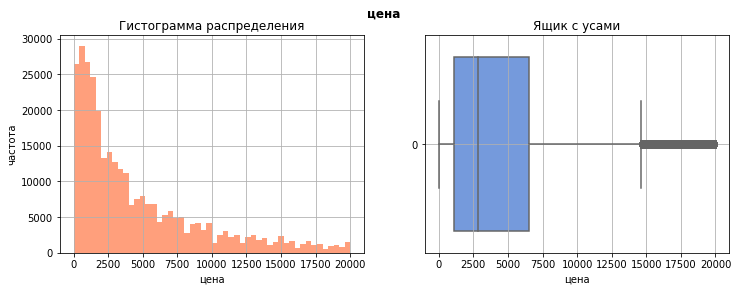

,count,mean,std,min,25%,50%,75%,max
price,309178.0,4487.898495,4565.099808,0.0,1100.0,2800.0,6500.0,20000.0


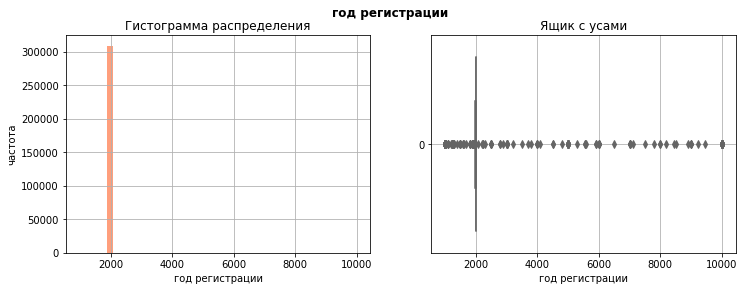

,count,mean,std,min,25%,50%,75%,max
registration_year,309178.0,2004.362875,92.563413,1000.0,1999.0,2003.0,2008.0,9999.0


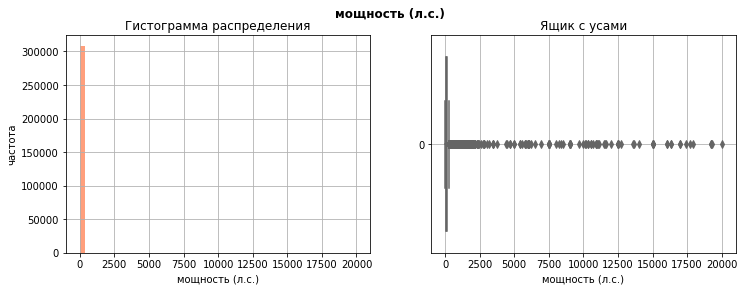

,count,mean,std,min,25%,50%,75%,max
power,309178.0,110.996976,201.009413,0.0,69.0,105.0,143.0,20000.0


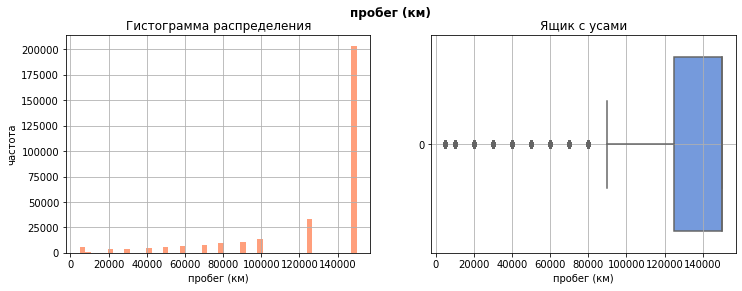

,count,mean,std,min,25%,50%,75%,max
kilometer,309178.0,127221.131516,38526.706414,5000.0,125000.0,150000.0,150000.0,150000.0


In [26]:
names = ['цена', 'год регистрации', 'мощность (л.с.)', 'пробег (км)']
p=0
for i in data.columns:
    if data[i].dtype == 'int':
        graph(data[i], 50, names[p])
        p+=1

**Цена:**

На ящике с усами видим, что статистически выбросами считаются значения выше 15000 евро. 
При этом максимальная цена - 22 тысячи евро, всего на 7000 тысяч выше верхнего нормального значения.

- Такой разброс кажется нормальным, поэтому эти значения выбросами не считаем.   
Выбросов нет

Но есть значения, равные 0 евро. Для построения модели такие данные не нужны.  
Возьмем минимальное значение цены от 100 евро. Проверим, какой процент датасета они составляют:

In [27]:
print ('Процент автомобилей стоимостью ниже 100 евро: ', round((data['price']<100).sum()/len(data)*100, 2))

Процент автомобилей стоимостью ниже 100 евро:  3.63


Менее 4%. Удаляем:

In [28]:
data = data.query('price>=100')

len(data)

297943

**Пробег**

Среднее 127 221 км со стандартным отклонением 38526.7 км.

Минимальный пробег - 5000 км.

Выбросов нет.

**Год регистрации**

Ранее видели, что все анкеты были созданы в 2016 году.

Удалим все автомобили, зарегистрированные позже 2016 года и до 1950.

In [29]:
print ('Процент автомобилей, зарегистрированных после 2016:', 
       round((data['registration_year']>2016).sum()/len(data)*100, 2))

print ('Процент автомобилей, зарегистрированных до 1950:', 
       round((data['registration_year']<1950).sum()/len(data)*100, 2))

Процент автомобилей, зарегистрированных после 2016: 4.31
Процент автомобилей, зарегистрированных до 1950: 0.05


In [30]:
# Удаляем лишние данные
data = data.query('registration_year <= 2016 and registration_year >= 1950')

Теперь распределение признака выглядит так:

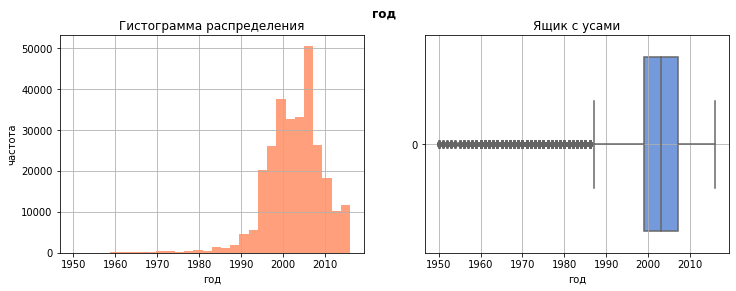

,count,mean,std,min,25%,50%,75%,max
registration_year,284974.0,2002.669068,6.899228,1950.0,1999.0,2003.0,2007.0,2016.0


In [31]:
graph(data['registration_year'], 30, 'год')

**Мощность**

Значения доходят до 20000 л.с. Это явные выбросы.

Наибольшая мощность по состоянию на 2022 была у Devel Sixteen Engine Dyno - 4515 л.с. Даже значения до 1500 л.с. - большая редкость.

Возьмем в итоговую выборку только значения до 500 л.с., не равные нулю

In [32]:
print ('Доля удаленных автомобилей - менее процента: \n', 
       round(len(data.query('power > 500 and power < 40'))/len(data)*100, 2))

# Убираем лишние значения 
data = data.query('power <= 500 and power > 40')

Доля удаленных автомобилей - менее процента: 
 0.0


##### Признаки типа Object

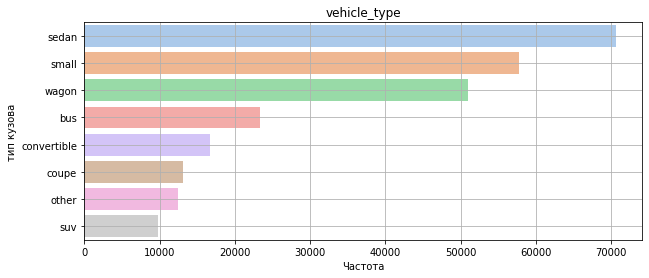

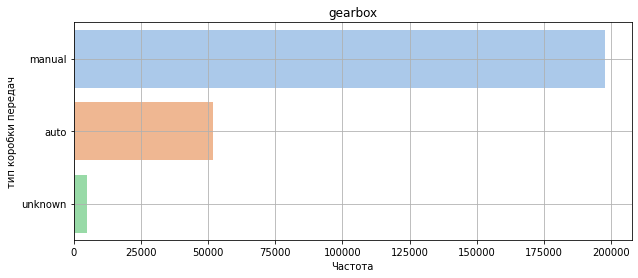

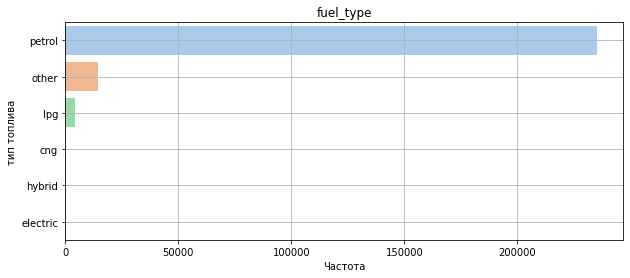

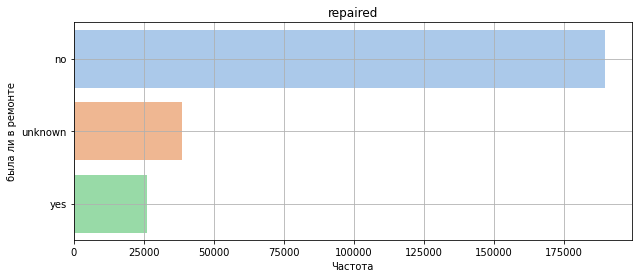

In [33]:
names = ['тип кузова', 'тип коробки передач', 'тип топлива', 'была ли в ремонте']
p=0
for i in data.columns:
    if data[i].dtype == 'O' and i not in ['model', 'brand'] :
        make_countplot(data, i, names[p])
        p +=1

**Вывод:**

Самые популярные типы кузова - sedan, small, wagon.

Коробка передач типа Manual количественно значительно преобладает над Auto.

Почти во всех случаях топливо - Petrol.

В основном в анкетах указано, что автомобиль не был в ремонте.

**model и brand**

У этих признаков очень много уникальных значений, поэтому визуализировать графиками их распределение сложно.

Представим результат в виде цифр.

**`model`:**

In [34]:
print ('Процент моделей, присутствующих в датасете в количестве меньше, чем... ')
for i in [10, 50, 100, 200, 400, 500, 1000, 2000, 3000]:
    print (f'{i} -', round((data['model'].value_counts()<i).sum()/data['model'].nunique() * 100, 2), '%')
    
print ('\n10 самых популярных: \n', (data['model'].value_counts().head(10)).index.to_list())
print ('\n10 наименее популярных: \n', (data['model'].value_counts().tail(10)).index.to_list())

Процент моделей, присутствующих в датасете в количестве меньше, чем... 
10 - 3.23 %
50 - 11.69 %
100 - 20.97 %
200 - 39.11 %
400 - 60.08 %
500 - 66.13 %
1000 - 81.45 %
2000 - 87.9 %
3000 - 92.34 %

10 самых популярных: 
 ['other', 'golf', '3er', 'polo', 'astra', 'corsa', 'a4', 'passat', 'c_klasse', '5er']

10 наименее популярных: 
 ['gl', 'amarok', 'elefantino', 'serie_2', 'i3', 'samara', 'kalina', 'serie_3', '601', 'range_rover_evoque']


Всего 10% моделей присутствуют в датасете в количестве менее 50 шт.  
Более 80% - в количестве более 100 шт.  
Около 50% - в количестве менее 400 шт.   
20% - более 1000 шт.  
Всего 10% - менее 3000.  

**`brand`**

In [35]:
print ('Всего брендов: ', data['brand'].nunique())

print ('\nПроцент присутствия в датасете:\n')
print ('10 наиболее популярных брендов - ',round(data['brand'].value_counts(normalize=True).head(10).sum()*100,2))
print ('10 наименее популярных брендов - ', round(data['brand'].value_counts(normalize=True).tail(10).sum(),2))

print ('\nПроцент присутствия в датасете: ')
round((data['brand'].value_counts(normalize=True))*100, 2)

Всего брендов:  40

Процент присутствия в датасете:

10 наиболее популярных брендов -  79.86
10 наименее популярных брендов -  0.01

Процент присутствия в датасете: 


volkswagen        20.59
bmw               10.78
opel              10.62
mercedes_benz      9.53
audi               8.70
ford               7.11
renault            4.70
peugeot            3.25
fiat               2.56
seat               2.03
skoda              1.75
mazda              1.67
smart              1.58
citroen            1.51
toyota             1.44
nissan             1.41
hyundai            1.11
mini               1.04
volvo              0.99
mitsubishi         0.91
honda              0.86
kia                0.74
alfa_romeo         0.71
suzuki             0.70
sonstige_autos     0.59
chevrolet          0.53
chrysler           0.43
dacia              0.29
subaru             0.24
porsche            0.22
daihatsu           0.22
jeep               0.21
saab               0.17
land_rover         0.17
jaguar             0.16
daewoo             0.15
lancia             0.14
rover              0.13
lada               0.06
trabant            0.01
Name: brand, dtype: float64

Самый часто встречаемый бренд - Volkswagen - каждый 5 автомобиль в датасете.

50% датасета представлено всего 4 брендами:
- volkswagen, opel, bmw, mercedes_benz

80% датасета представлено 10 брендами.

10 брендов (четверть от всех) имеют лишь 2% в датасете.

### **Вывод по предобработке данных**

Столбцы переименованы: приведены к нижнему регистру, добавлены разграничители "_".

Удалены неинформативные признаки:
- date_crawled, date_created, lastseen, 'postalcode', 'registration_month', 'number_of_pictures'

Пропуски заполнены:
- 'fuel_type', 'model', 'vehicle_type' - на существующую категорию 'other'
- 'repaired', 'gearbox' - на новую категорию 'unknown'

Удалено явных дубликатов: 45191 (12.75% изначального датасета)

Неявные дубликаты:
- В `fuel_type` заменили *gasoline* на *petrol*

27% датасета пришлось удалить: из-за дубликатов, выбросов или нулевых значений.
Около половины удаленных объектов - дубликаты (45191 шт)

Удаленные объекты:
- Цена ниже 100 евро
- Автомобили, зарегистрированные позже 2016 года и до 1950
- Мощность меньше 40 или выше 500 л.с.


## **Корреляционный анализ**

Построим матрицы корреляции и визуализируем зависимости через scatterplot:

In [36]:
interval_cols = ['power', 'kilometer', 'price']

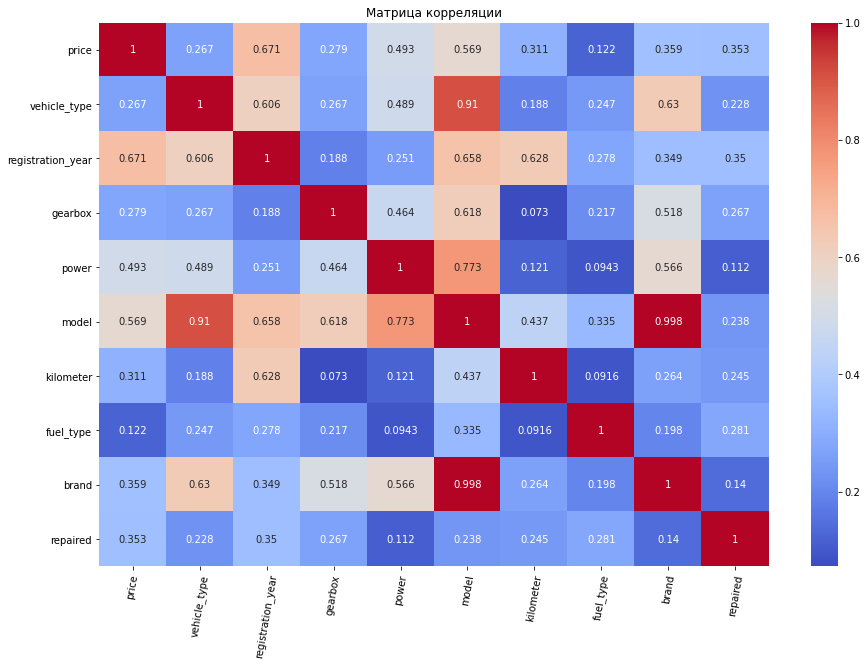

In [37]:
figsize = (8,8)
fig, ax = plt.subplots(figsize=(15,10))
plt.title('Матрица корреляции')
sns.heatmap(data.phik_matrix(interval_cols=interval_cols), ax=ax, annot=True, fmt='.3g', cmap='coolwarm')
plt.xticks(rotation=80)
plt.show()

Видим мультиколлинеарность между признаками `model` и `brand`. 

Просто удалять признак `brand` было бы некорректно, т.к. есть много значений 'other' в `model`, а также некоторые наименования моделей повторяются у разных брендов.

Выведем 10 таких значений ниже:

In [38]:
print ('Модель и количество брендов, в которых она присутствует:')

data.groupby('model')['brand'].nunique().sort_values(ascending=False).head(10)

Модель и количество брендов, в которых она присутствует:


model
other          40
grand           3
3_reihe         2
freelander      2
discovery       2
range_rover     2
1_reihe         2
defender        2
matiz           2
5_reihe         2
Name: brand, dtype: int64

Для решения проблемы объединим названия бренда и модели автомобиля в один новый признак, а `model` и `brand` - удалим:

In [39]:
# Создадим новый признак brand+model
data['brand_model'] = data['brand']+'_'+data['model']

# Удаляем признак brand
data = data.drop(['brand', 'model'], axis=1)
#data = data.drop('brand', axis=1)

data.head()

,price,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,repaired,brand_model
1,18300,coupe,2011,manual,190,125000,petrol,yes,audi_other
2,9800,suv,2004,auto,163,125000,petrol,unknown,jeep_grand
3,1500,small,2001,manual,75,150000,petrol,no,volkswagen_golf
4,3600,small,2008,manual,69,90000,petrol,no,skoda_fabia
5,650,sedan,1995,manual,102,150000,petrol,yes,bmw_3er


* успешно.

Еще раз строим матрицу корреляции:

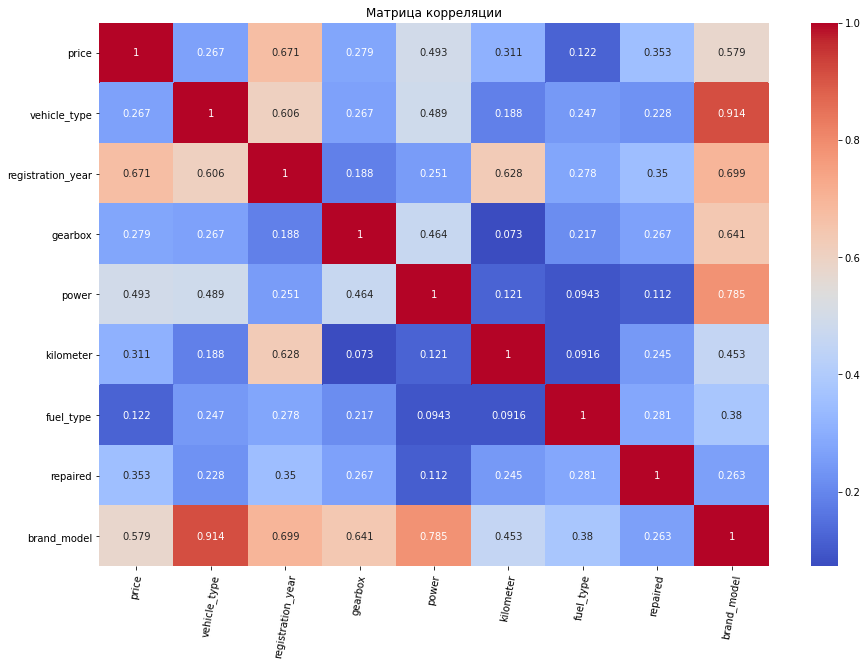

In [40]:
figsize = (8,8)
fig, ax = plt.subplots(figsize=(15,10))
plt.title('Матрица корреляции')
sns.heatmap(data.phik_matrix(interval_cols=interval_cols), ax=ax, annot=True, fmt='.3g', cmap='coolwarm')
plt.xticks(rotation=80)
plt.show()

### Вывод

Наибольшая (средняя) корреляция с `price`:
- registration_year - 0.671
- brand_model - 0.579
- power - 0.493

Корреляция есть, но не высокая:
- kilometer - 0.311
- repaired - 0.353
- vehicle_type - 0.267
- gearbox - 0.279


Есть высокая коллинеарность также между входными признаками `model` и `vehicle_type`. Тем не менее, оставим их, т.к. для разных моделей могут быть разные типы кузова.



## **Обучение моделей**

### Подготовка выборок

Разделим выборку на X (входные признаки) и Y (целевой):

In [41]:
#data.reset_index(drop=True, inplace=True)

X = data.drop('price', axis=1)
y = data['price']

print (f'---X:\nРазмер: {X.shape}\nПервые строки: \n{X.head(2)}')
print (f'\n---y:\nРазмер: {y.shape}\nПервые строки: \n{y.head(2)}')

---X:
Размер: (254682, 8)
Первые строки: 
  vehicle_type  registration_year gearbox  power  kilometer fuel_type  \
1        coupe               2011  manual    190     125000    petrol   
2          suv               2004    auto    163     125000    petrol   

  repaired brand_model  
1      yes  audi_other  
2  unknown  jeep_grand  

---y:
Размер: (254682,)
Первые строки: 
1    18300
2     9800
Name: price, dtype: int64


Создаем тренировочную, валидационную и тестовую выборку в соотношении 6/2/2:

In [42]:
X_train, X_val_test, y_train, y_val_test = train_test_split(
    X, y, test_size=0.4, random_state=RANDOM_STATE)

X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.5, random_state=RANDOM_STATE)

### Пайплайн

Определим списки с названиями признаков:

In [43]:
ohe_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'brand_model', 'repaired']
num_columns = ['registration_year', 'power', 'kilometer']

Preprocessor с кодировщиком и скейлером:

In [44]:
ohe_pipe = Pipeline(
    [
        ('SimpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns), 
    ('num', StandardScaler(), num_columns)
], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor), 
    ('models', LinearRegression())
])

Закодированные и масштабированные признаки:

In [45]:
X_train_p = data_preprocessor.fit_transform(X_train)
X_val_p = data_preprocessor.transform(X_val)
X_test_p = data_preprocessor.transform(X_test)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### LinearRegression

Обучим модель, предскажем значения, посчитаем RMSE, выведем время обучения и предсказания:

In [46]:
model = LinearRegression()

start = time.time()

model.fit(X_train_p, y_train)
# Время обучения
lr_fit_time = time.time() - start

preds_lr = model.predict(X_val_p)
# Время предсказания
lr_pred_time = time.time() - lr_fit_time - start

rmse_lr = root_mean_squared_error(y_val, preds_lr)
print ('RMSE: ', round(rmse_lr, 2))
print ('Время обучения: ', round(lr_fit_time, 2))
print ('Время предсказания: ', round(lr_pred_time, 2))

RMSE:  2672.18
Время обучения:  17.81
Время предсказания:  0.1


**Итог:**

- Результат метрики неудовлетворительный, выше необходимых 2500.
- Скорость работы высокая

### DecisionTreeRegressor

Подберем подходящие гиперпараметры:

In [47]:
for i in range(24, 28):
    for s in range(5, 8):
        model = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=i, min_samples_leaf=s)
        model.fit(X_train_p, y_train)
        preds = model.predict(X_val_p)
        print (f'max_depth={i}, min_samples_leaf={s}: ', round(root_mean_squared_error(preds, y_val), 2))

max_depth=24, min_samples_leaf=5:  1863.14
max_depth=24, min_samples_leaf=6:  1857.71
max_depth=24, min_samples_leaf=7:  1864.95
max_depth=25, min_samples_leaf=5:  1861.65
max_depth=25, min_samples_leaf=6:  1855.91
max_depth=25, min_samples_leaf=7:  1862.19
max_depth=26, min_samples_leaf=5:  1860.79
max_depth=26, min_samples_leaf=6:  1855.83
max_depth=26, min_samples_leaf=7:  1862.06
max_depth=27, min_samples_leaf=5:  1861.32
max_depth=27, min_samples_leaf=6:  1854.76
max_depth=27, min_samples_leaf=7:  1862.46


* Лучшие результаты получились при *max_depth=27, min_samples_leaf=6*.


Запишем результаты в переменные, посчитаем время обучения и предсказания:

In [48]:
model = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=27, min_samples_leaf=6)

start = time.time()

model.fit(X_train_p, y_train)
# Время обучения
dt_fit_time = time.time() - start

preds = model.predict(X_val_p)
preds_dt = preds.copy()
# Время предсказания
dt_pred_time = time.time() - dt_fit_time - start

rmse_dt = root_mean_squared_error(y_val, preds)
print ('RMSE: ', round(rmse_dt, 2))
print ('Время обучения: ', round(dt_fit_time, 2))
print ('Время предсказания: ', round(dt_pred_time, 2))

RMSE:  1854.76
Время обучения:  6.31
Время предсказания:  0.06


**Итог:**

* Неплохое значение RMSE (1854.76)
* Быстрое обучениe и предсказаниe (6 с и 0.05 с)

### CatBoostRegressor

Попробуем найти подходящие гиперпараметры max_depth, learning_rate и l2_leaf_reg при одинаковом iterations=50 с помощью перебора:

In [49]:
# Задаем категориальные переменные
cat_features = ohe_columns.copy()

С помощью Optuna осуществим перебор гиперпараметров:

In [51]:
def fit_catboost(trial):
    # Прописываем гиперпараметры и задаем области значений
    param = {
        'iterations' : trial.suggest_int("iterations", 130, 160),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.5),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 5, 20),
        "depth": trial.suggest_int("depth", 7, 16),
        "eval_metric": "RMSE",
    }      
    
    # Инициируем модель 
    model = CatBoostRegressor(**param, cat_features=cat_features, random_seed=RANDOM_STATE)
    
    #Обучаем
    model.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        verbose=0,
        plot=False,
        early_stopping_rounds=5,
    )
    
    # Предсказываем таргет по значениям входных признаков валидационной выборки
    pred_val = model.predict(X_val)
    return root_mean_squared_error(y_val, pred_val)

In [53]:
study = optuna.create_study(direction='minimize')
# Запускаем перебор
study.optimize(fit_catboost, n_trials=10, n_jobs =-1, show_progress_bar=True)

# Выводим на экран гиперпараметры лучшей модели и значение метрики
print("Best hyperparameters: ", study.best_params)
print("Best rmse: ", study.best_value) 

[I 2025-04-14 00:23:29,979] A new study created in memory with name: no-name-b0e53e31-2a89-4a1f-a4d9-2bba8cfae1a2


  0%|          | 0/10 [00:00<?, ?it/s]

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

[I 2025-04-14 00:26:00,871] Trial 0 finished with value: 1724.8364562750771 and parameters: {'iterations': 131, 'learning_rate': 0.4075899545409929, 'l2_leaf_reg': 11, 'depth': 9}. Best is trial 0 with value: 1724.8364562750771.
[I 2025-04-14 00:26:08,267] Trial 1 finished with value: 1815.87853700829 and parameters: {'iterations': 150, 'learning_rate': 0.06482579629347694, 'l2_leaf_reg': 20, 'depth': 8}. Best is trial 0 with value: 1724.8364562750771.
[I 2025-04-14 00:26:52,472] Trial 4 finished with value: 1706.234604584875 and parameters: {'iterations': 141, 'learning_rate': 0.46702470544389785, 'l2_leaf_reg': 10, 'depth': 11}. Best is trial 4 with value: 1706.234604584875.
[I 2025-04-14 00:27:17,471] Trial 7 finished with value: 1710.2754684756183 and parameters: {'iterations': 150, 'learning_rate': 0.21993966626696726, 'l2_leaf_reg': 7, 'depth': 11}. Best is trial 4 with value: 1706.234604584875.
[I 2025-04-14 00:27:24,780] Trial 6 finished with value: 1709.1102953138188 and param

**Результат:**

Лучшая модель, гиперпараметры:
- {'iterations': 150, 'learning_rate': 0.49145274841484277, 'l2_leaf_reg': 19, 'depth': 14}

Её RMSE: 
- 1689.97 




Обучим модель при этих гиперпараметрах, засечем время обучения и предсказания:

In [54]:
model = catboost.CatBoostRegressor(loss_function='RMSE', iterations=150, 
                                     depth=14, l2_leaf_reg=19, learning_rate=0.49145)

start = time.time()

model.fit(X_train, y_train, cat_features=cat_features, verbose=50)
# Время обучения
cb_fit_time = time.time() - start

preds = model.predict(X_val)
preds_cb = preds.copy()
# Время предсказания
cb_pred_time = time.time() - cb_fit_time - start

# Результат RMSE
rmse_cb = root_mean_squared_error(y_val, preds)


print ('RMSE: ', rmse_cb)
print ('Время обучения: ', round(cb_fit_time, 2))
print ('Время предсказания: ', round(cb_pred_time, 2))

0:	learn: 3117.6843867	total: 330ms	remaining: 49.1s
50:	learn: 1561.4148015	total: 16.2s	remaining: 31.4s
100:	learn: 1484.4211773	total: 30.9s	remaining: 15s
149:	learn: 1425.5507725	total: 45.7s	remaining: 0us
RMSE:  1696.0298942382328
Время обучения:  46.9
Время предсказания:  0.1


**Итог**

- Хороший результат метрики RMSE - 1696 

- Время обучения 47 сек.

- Время предсказания 0.1 с

### LightGBM

Так же воспользуемся Optuna для подбора гиперпараметров:

In [55]:
def fit_lgbm(trial):

    param = {
        'n_estimators' : trial.suggest_int("n_estimators", 450, 550),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.5),
        "max_depth": trial.suggest_int("max_depth", 5, 16)
    }      

    model = LGBMRegressor(**param, random_state=RANDOM_STATE)

    model.fit(
        X_train_p,
        y_train,
        eval_set=(X_val_p, y_val),
        verbose=0,
        eval_metric = 'rmse',
        early_stopping_rounds=5
    )

    pred_val = model.predict(X_val_p)
    return root_mean_squared_error(y_val, pred_val)

In [56]:
study = optuna.create_study(direction='minimize')

study.optimize(fit_lgbm, n_trials=10, show_progress_bar=True)

print("Best hyperparameters: ", study.best_params)
print("Best rmse: ", study.best_value) 

[I 2025-04-14 00:32:10,285] A new study created in memory with name: no-name-bea0f42e-7774-42b6-9f9b-f0b83a76a0a6


  0%|          | 0/10 [00:00<?, ?it/s]

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

[I 2025-04-14 00:43:33,892] Trial 0 finished with value: 1629.505048821766 and parameters: {'n_estimators': 533, 'learning_rate': 0.15459959649707528, 'max_depth': 16}. Best is trial 0 with value: 1629.505048821766.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

[I 2025-04-14 00:45:20,970] Trial 1 finished with value: 1630.0604992328579 and parameters: {'n_estimators': 466, 'learning_rate': 0.31853112683408646, 'max_depth': 11}. Best is trial 0 with value: 1629.505048821766.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

[I 2025-04-14 00:45:29,569] Trial 2 finished with value: 1658.8039229620042 and parameters: {'n_estimators': 501, 'learning_rate': 0.46994426060993355, 'max_depth': 13}. Best is trial 0 with value: 1629.505048821766.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

[I 2025-04-14 00:45:41,585] Trial 3 finished with value: 1635.9107340029432 and parameters: {'n_estimators': 536, 'learning_rate': 0.274741507342579, 'max_depth': 9}. Best is trial 0 with value: 1629.505048821766.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

[I 2025-04-14 00:45:52,072] Trial 4 finished with value: 1654.0772688117663 and parameters: {'n_estimators': 522, 'learning_rate': 0.47777000473957476, 'max_depth': 9}. Best is trial 0 with value: 1629.505048821766.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

[I 2025-04-14 00:46:03,779] Trial 5 finished with value: 1651.806499027658 and parameters: {'n_estimators': 504, 'learning_rate': 0.23010844785498433, 'max_depth': 11}. Best is trial 0 with value: 1629.505048821766.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

[I 2025-04-14 00:46:10,862] Trial 6 finished with value: 1669.5231484357737 and parameters: {'n_estimators': 460, 'learning_rate': 0.47691055702312113, 'max_depth': 7}. Best is trial 0 with value: 1629.505048821766.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

[I 2025-04-14 00:46:31,170] Trial 7 finished with value: 1653.5687003258474 and parameters: {'n_estimators': 452, 'learning_rate': 0.0889584799300736, 'max_depth': 13}. Best is trial 0 with value: 1629.505048821766.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

[I 2025-04-14 00:46:46,982] Trial 8 finished with value: 1631.6111846156284 and parameters: {'n_estimators': 486, 'learning_rate': 0.19089285429342465, 'max_depth': 13}. Best is trial 0 with value: 1629.505048821766.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

[I 2025-04-14 00:46:59,880] Trial 9 finished with value: 1645.1159106859568 and parameters: {'n_estimators': 479, 'learning_rate': 0.3086651372652668, 'max_depth': 6}. Best is trial 0 with value: 1629.505048821766.
Best hyperparameters:  {'n_estimators': 533, 'learning_rate': 0.15459959649707528, 'max_depth': 16}
Best rmse:  1629.505048821766


Лучшая модель следующая:
- LGBMRegressor(learning_rate=0.159, max_depth=15, n_estimators=519)

Обучим, засечем время:

In [57]:
model_lgbm = LGBMRegressor(learning_rate=0.159, max_depth=15, n_estimators=519)

start = time.time()

model_lgbm.fit(X_train_p, y_train, eval_metric='rmse')

# Записываем время обучения
lgbm_fit_time = time.time() - start

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Делаем предсказания, засекаем:

In [58]:
start = time.time()
preds_lgbm = model_lgbm.predict(X_val_p)

lgbm_pred_time = time.time() - start

# Считаем значение RMSE
rmse_lgbm = root_mean_squared_error (y_val, preds_lgbm)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


**Результат:**

In [59]:
print ('RMSE: ', round(rmse_lgbm, 2))
print ('Время обучения: ', round(lgbm_fit_time, 2))
print ('Время предсказания: ', round(lgbm_pred_time, 2))

RMSE:  1626.53
Время обучения:  13.7
Время предсказания:  1.99


* Хорошее значение метрики и довольно высокая скорость обучения.

### Анализ остатков:

In [60]:
# Для анализа остатков:
def make_hist(df, column, bins, p, x_name, title):
    f, ax = plt.subplots(1, 2)
    f.set_size_inches(20, 5)
    plt.suptitle(f'{p}', fontweight='bold')
    # Гистограмма:
    sns.histplot(data=df, x=column, bins=bins, color='coral', edgecolor=None, ax=ax[0])
    ax[0].set_title(f'{title}')
    ax[0].grid()
    ax[0].set_xlabel(x_name)
    ax[0].set_ylabel('частота')
    # Ящик с усами:
    ## vert=False, чтобы значения признака были по горизонтальной оси для обоих графиков
    sns.boxplot(data=df, x=column, orient='h', color='cornflowerblue')
    ax[1].set_title(f'Ящик с усами')
    ax[1].grid()
    ax[1].set_xlabel(x_name)
    plt.show()
    
def build_joint_hist(y_test, y_pred, df_num, title):
    y_joint = pd.DataFrame(list(zip(y_test, y_pred)), columns=['y_val', 'y_pred'])
    make_hist(y_joint, None, 50, df_num, 'евро', title)
    display(y_joint.describe().T)

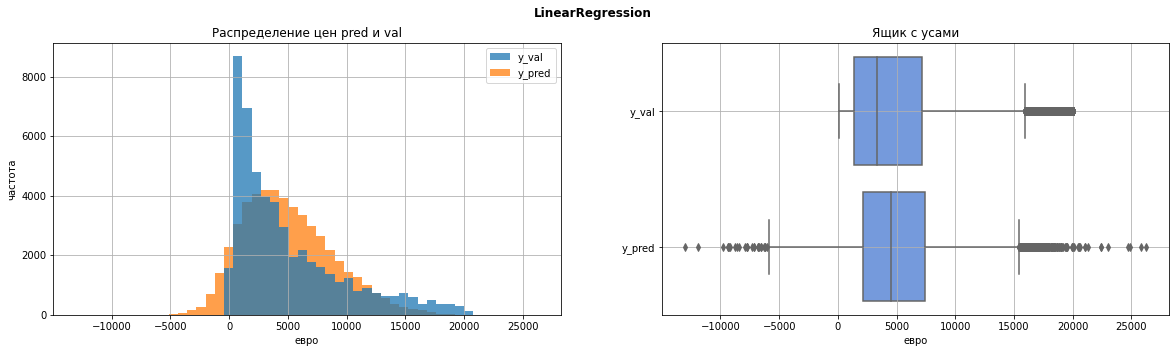

,count,mean,std,min,25%,50%,75%,max
y_val,50936.0,4988.195971,4685.234516,100.000000,1400.000000,3300.000000,7200.000000,20000.000000
y_pred,50936.0,4981.900251,3875.110532,-13007.432989,2097.991349,4508.562004,7436.387379,26260.454972


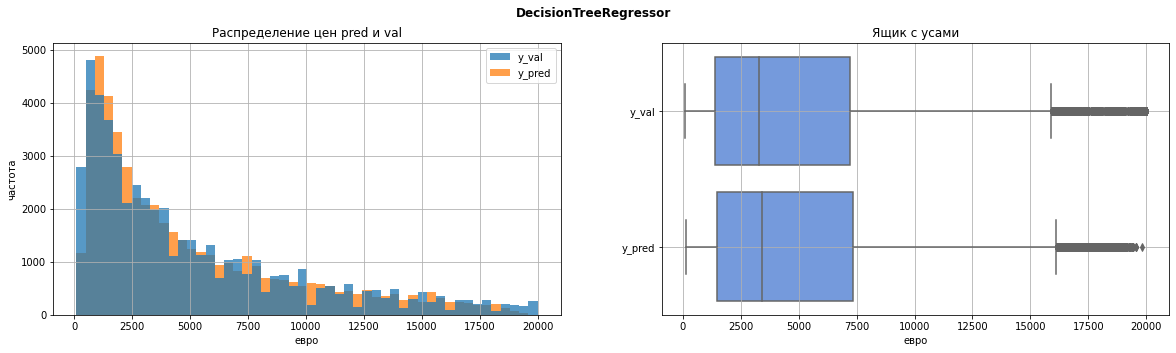

,count,mean,std,min,25%,50%,75%,max
y_val,50936.0,4988.195971,4685.234516,100.000000,1400.000000,3300.000000,7200.000000,20000.000000
y_pred,50936.0,4986.278817,4430.992842,141.428571,1492.714286,3398.888889,7343.461538,19799.833333


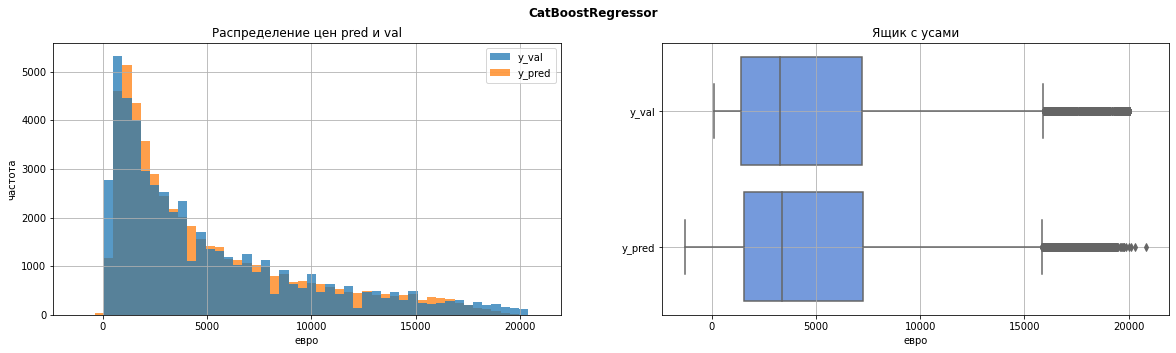

,count,mean,std,min,25%,50%,75%,max
y_val,50936.0,4988.195971,4685.234516,100.000000,1400.000000,3300.00000,7200.00000,20000.000000
y_pred,50936.0,4992.860283,4408.056394,-1272.244809,1545.195588,3395.44494,7271.87129,20850.032691


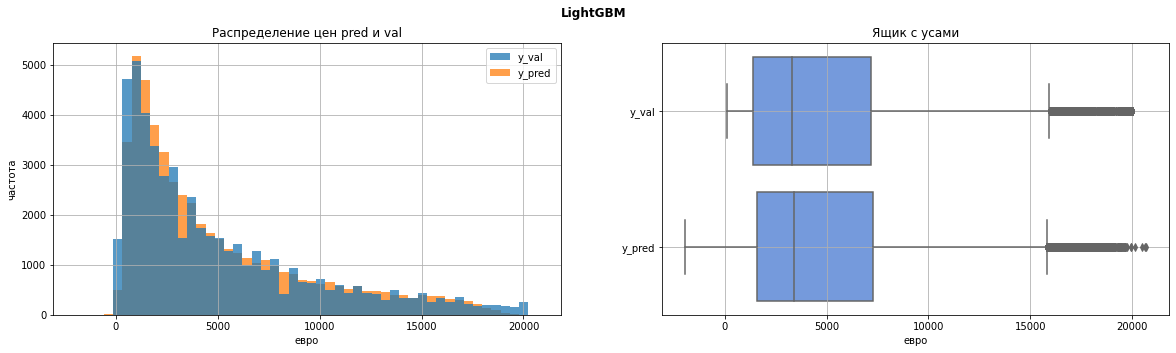

,count,mean,std,min,25%,50%,75%,max
y_val,50936.0,4988.195971,4685.234516,100.000000,1400.00000,3300.000000,7200.000000,20000.000000
y_pred,50936.0,4994.047826,4417.155942,-1944.407723,1568.52556,3407.683262,7260.551269,20692.181606


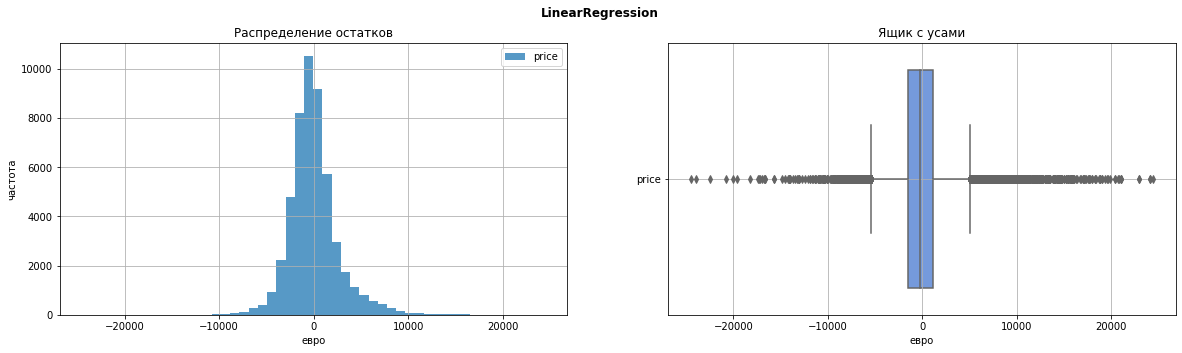

,count,mean,std,min,25%,50%,75%,max
price,50936.0,6.295721,2672.199699,-24449.713908,-1494.047725,-242.870706,1117.875583,24349.651055


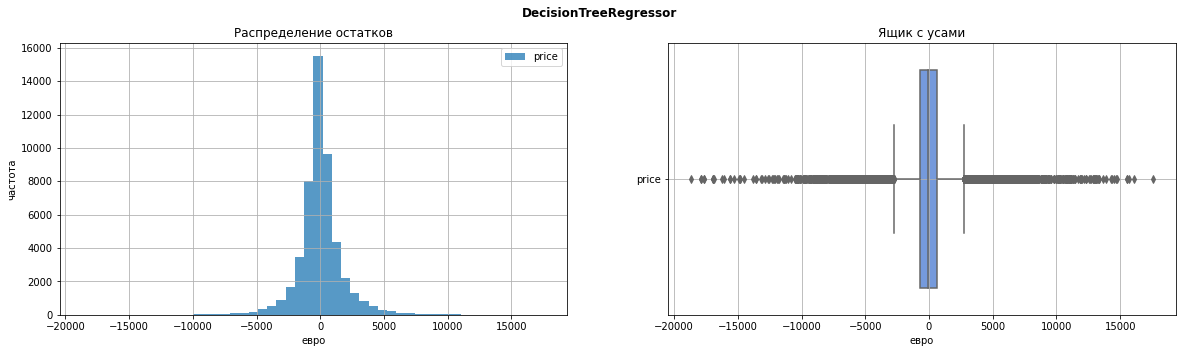

,count,mean,std,min,25%,50%,75%,max
price,50936.0,1.917154,1854.774364,-18632.0,-722.934336,-76.357143,650.333333,17544.0


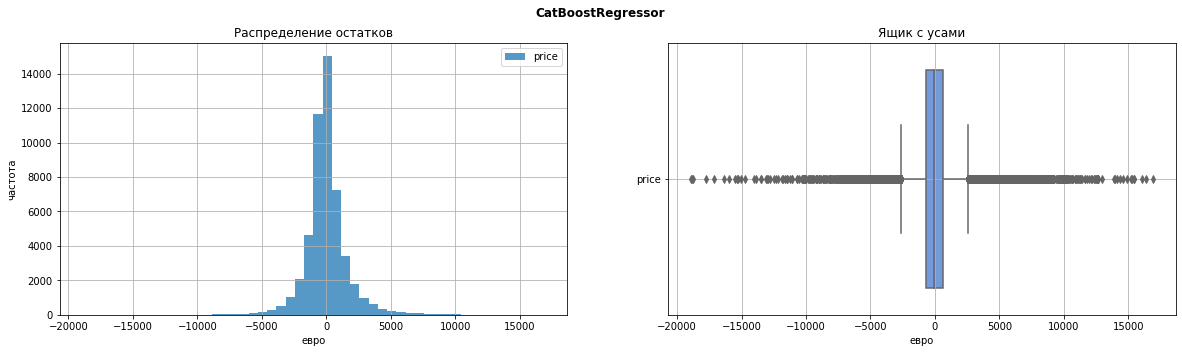

,count,mean,std,min,25%,50%,75%,max
price,50936.0,-4.664311,1696.040129,-18881.755835,-699.624145,-90.089312,601.702544,16882.206715


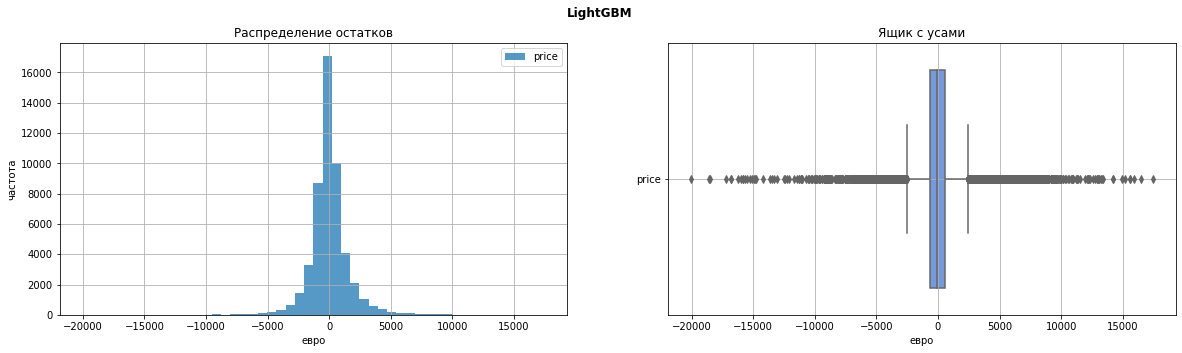

,count,mean,std,min,25%,50%,75%,max
price,50936.0,-5.851854,1626.536382,-20003.352648,-672.280205,-84.637874,578.517648,17426.128776


In [61]:
# посмотрим, как распределяются значения таргета реальные и предсказанные
names = ['LinearRegression', 'DecisionTreeRegressor', 'CatBoostRegressor', 'LightGBM']
p=0
for i in [preds_lr, preds_dt, preds_cb, preds_lgbm]:
    build_joint_hist(y_val, i, names[p], 'Распределение цен pred и val')
    p+=1
    
# Распределение остатков
p=0
for i in [preds_lr, preds_dt, preds_cb, preds_lgbm]:
    make_hist(pd.DataFrame(y_val - i), None, 50, names[p], 'евро', 'Распределение остатков')
    display(pd.DataFrame((y_val - i).describe()).T)
    p+=1

Видно, что модели иногда предсказывают отрицательные значения.

Попробуем решить эту проблему следующим образом на примере LGBM:
- всем предсказаным значения ниже 100 (такую минимальную цену приняли на этапе подготовки данных) присвоим минимальную цену - 100 евро, затем посмотрим значение метрики RMSE

In [62]:
print ('Количество значений ниже 100 до обработки: ', (preds_lgbm<100).sum())
print ('RMSE до обработки:', round(root_mean_squared_error(y_val, preds_lgbm), 2))

for i in range(len(preds_lgbm)):
    if preds_lgbm[i]<100:
        preds_lgbm[i] = 100
        
print ('\nКоличество значений ниже 100 после обработки: ', (preds_lgbm<100).sum())
print ('RMSE после обработки:', round(root_mean_squared_error(y_val, preds_lgbm), 2))

Количество значений ниже 100 до обработки:  79
RMSE до обработки: 1626.53

Количество значений ниже 100 после обработки:  0
RMSE после обработки: 1626.38


Небольшое количество значений ниже 100 евро убрали.

Метрика незначительно улучшилась.

**Вывод**

1. По графику распределения цен видим, что модели иногда предсказывали даже отрицательные значения цены. 
   - Таким значениям можно присваивать минимальную цену (в нашем случае - 100 евро)
   

2. На ящиках с усами верхние границы предсказанных цен, не являющихся выбросами, почти на том же уровне, что у реальных.

3. Медиана цены у предсказанных значений у каждой модели чуть выше среднего валидационной выборки.

**Распределение остатков:**

- Наиболее близкое к нулю среднее распределение остатков у Дерева Решений - 1.9. 
- Наименьший размах у дерева решений и CatBoost'а - от примерно -19 тыс до 17 тыс.
- Наименьшее стандартное отклонение у LGBM.

### **Вывод  по обучению моделей**

В начале выполнена подготовка данных:

- выборка разбита на тренировочную, валидационную и тестовую в соотношении 6/2/2
- составлен пайплайн подготовки данных: кодирование через OHE и масштабирование - StandardScaler

Построили 4 модели:
- LinearRegression (Высокий RMSE, быстрая скорость обучения)
- DecisionTreeRegressor (Неплохой результат RMSE, высокая скорость обучения)
- CatBoostRegressor (Хороший RMSE, средняя скорость обучения)
- LightGBM (Хороший RMSE, высокая скорость обучения)

Проведен анализ остатков:
- Некоторые предсказанные значения - отрицательны. Таким объектам можно присваивать минимальную цену 100 евро.
- Среднее остатков - близко к нулю
- Наименьший размах - у CatBoost'а - от примерно -19 тыс до 17 тыс.

## **Анализ моделей**

Сравним результаты метрики, время обучения и предсказания моделей:

In [63]:
rmse_s = [rmse_lr, rmse_dt, rmse_cb, rmse_lgbm]
fit_times = [lr_fit_time, dt_fit_time, cb_fit_time, lgbm_fit_time]
pred_times = [lr_pred_time, dt_pred_time, cb_pred_time, lgbm_pred_time]
names=['LinearRegression', 'DecisionTreeRegressor', 'CatBoostRegressor', 'LightGBM']
p=0
for i in rmse_s:
    print (f'\n  ____ {names[p]} ____')
    print (f'RMSE: {round(i, 2)}')
    print (f'Время обучения: {round(fit_times[p], 2)} с')
    print (f'Время предсказания: {round(pred_times[p], 2)} с')
    p+=1


  ____ LinearRegression ____
RMSE: 2672.18
Время обучения: 17.81 с
Время предсказания: 0.1 с

  ____ DecisionTreeRegressor ____
RMSE: 1854.76
Время обучения: 6.31 с
Время предсказания: 0.06 с

  ____ CatBoostRegressor ____
RMSE: 1696.03
Время обучения: 46.9 с
Время предсказания: 0.1 с

  ____ LightGBM ____
RMSE: 1626.53
Время обучения: 13.7 с
Время предсказания: 1.99 с


**Вывод:**

LinearRegression дал результат выше допустимого уровня RMSE.

DecisionTreeRegressor показал неплохой результат и самое быстрое время обучения и предсказания.

Наилучшее значение RMSE - у LightGBM. 

У CatBoostRegressor самое быстрое время предсказания, на полторы секунды быстрее LGBM. 

Но значительно дольше время обучения - более 47 секунд против 15 у LGBM.  

**Решение:**
- **По совокупности факторов выбираем модель LightGBM.**


### Проверка модели LightGBM на тестовой выборке

Делаем предсказания:

In [64]:
start = time.time()
preds_test = model_lgbm.predict(X_test_p)

lgbm_pred_test = time.time() - start

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Назначаем минимальную цену:

In [65]:
print ('Количество отрицательных значений до обработки:', (preds_test<0).sum())
print ('Количество значений ниже 100 до обработки:', (preds_test<100).sum())

for i in range (len(preds_test)):
    if preds_test[i]<100:
        preds_test[i]=100
        
print ('Количество отрицательных значений после обработки:', (preds_test<0).sum())
print ('Количество значений ниже 100 после обработки:', (preds_test<100).sum())

Количество отрицательных значений до обработки: 44
Количество значений ниже 100 до обработки: 86
Количество отрицательных значений после обработки: 0
Количество значений ниже 100 после обработки: 0


### Результат

In [66]:
rmse_test = root_mean_squared_error(y_test, preds_test)
print ('RMSE: ', round(rmse_test, 2))
print ('Время предсказания: ', round(lgbm_pred_test, 2))

RMSE:  1588.03
Время предсказания:  1.93


* Качество чуть улучшилось в сравнении с валидационными значениями, результат хороший.  
Время работы почти такое же, как было на валидационной выборке.

### **Общий вывод**

**Результат:**

Построены модели и выбрана лучшая по соотношению качества и скоростей обучения и предсказания:
- **LGBMRegressor(learning_rate=0.159, max_depth=15, n_estimators=519)**

Её результаты:
1. На валидационной выборке:
    - RMSE:  1626.53
    - Время обучения:  14.58 с 
    - Время предсказания:  1.93 с
    
    
2. На тестовой выборке:
    - RMSE:  1588.03
    - Время предсказания:  1.95 с

**Ход работы:**

1. *Подготовка данных*

Изначально имели следующий датасет:
- 354369 строк, 16 столбцов.
- Типы: int - 7 столбцов, object - 9 столбцов.

Удалены неинформативные признаки:
- date_crawled, date_created, lastseen, 'postalcode', 'registration_month', 'number_of_pictures'

Пропуски заполнены:
- 'fuel_type', 'model', 'vehicle_type' - на существующую категорию 'other'
- 'repaired', 'gearbox' - на новую категорию 'unknown'

В `fuel_type` заменили *gasoline* на *petrol*

Удалено явных дубликатов: 45191 (12.75% изначального датасета)

27% датасета пришлось удалить: из-за дубликатов, выбросов или нулевых значений.
Около половины удаленных объектов - дубликаты (45191 шт)

Удаленные объекты:
- Цена ниже 100 евро
- Автомобили, зарегистрированные позже 2016 года и до 1950
- Мощность меньше 40 л.с. или выше 500 л.с.

2. *Обучение моделей:*

В начале выполнена подготовка данных:

- выборка разбита на тренировочную, валидационную и тестовую в соотношении 6/2/2
- составлен пайплайн подготовки данных: кодирование через OHE и масштабирование - StandardScaler

Построено 4 модели:
- LinearRegression ()
- DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=27, min_samples_leaf=6)
- CatBoostRegressor(loss_function='RMSE', iterations=150, depth=14, l2_leaf_reg=19, learning_rate=0.49145))
- LGBMRegressor(learning_rate=0.159, max_depth=15, n_estimators=519)

Анализ моделей:

____ LinearRegression: 
RMSE: 2672.18
Время обучения: 15.56 с
Время предсказания: 0.1 с

  ____ DecisionTreeRegressor: 
RMSE: 1854.76
Время обучения: 6.02 с
Время предсказания: 0.06 с

  ____ CatBoostRegressor: 
RMSE: 1696.03
Время обучения: 47.05 с
Время предсказания: 0.11 с

  ____ LightGBM: 
RMSE: 1626.53
Время обучения: 14.58 с
Время предсказания: 1.93 с


**Решение:**
- **По совокупности факторов выбирали модель LightGBM: один из лучших RMSE, наряду с CatBoost, а также низкое время обучения и предсказания**